#### Importing libraries and the dataset:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import operator
from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_target = pd.read_csv('data/test_target.csv')

### Info given on the dataset:
<hr>
#### Attribute Information:
Number of Attributes: 61 (58 predictive attributes, 2 non-predictive, 1 goal field)
<hr>
#### Attribute Information:
0. url: URL of the article (non-predictive)
1. timedelta: Days between the article publication and the dataset acquisition (non-predictive)
2. n_tokens_title: Number of words in the title
3. n_tokens_content: Number of words in the content
4. n_unique_tokens: Rate of unique words in the content
5. n_non_stop_words: Rate of non-stop words in the content
6. n_non_stop_unique_tokens: Rate of unique non-stop words in the content
7. num_hrefs: Number of links
8. num_self_hrefs: Number of links to other articles published by Mashable
9. num_imgs: Number of images
10. num_videos: Number of videos
11. average_token_length: Average length of the words in the content
12. num_keywords: Number of keywords in the metadata
13. data_channel_is_lifestyle: Is data channel 'Lifestyle'?
14. data_channel_is_entertainment: Is data channel 'Entertainment'?
15. data_channel_is_bus: Is data channel 'Business'?
16. data_channel_is_socmed: Is data channel 'Social Media'?
17. data_channel_is_tech: Is data channel 'Tech'?
18. data_channel_is_world: Is data channel 'World'?
19. kw_min_min: Worst keyword (min. shares)
20. kw_max_min: Worst keyword (max. shares)
21. kw_avg_min: Worst keyword (avg. shares)
22. kw_min_max: Best keyword (min. shares)
23. kw_max_max: Best keyword (max. shares)
24. kw_avg_max: Best keyword (avg. shares)
25. kw_min_avg: Avg. keyword (min. shares)
26. kw_max_avg: Avg. keyword (max. shares)
27. kw_avg_avg: Avg. keyword (avg. shares)
28. self_reference_min_shares: Min. shares of referenced articles in Mashable
29. self_reference_max_shares: Max. shares of referenced articles in Mashable
30. self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
31. weekday_is_monday: Was the article published on a Monday?
32. weekday_is_tuesday: Was the article published on a Tuesday?
33. weekday_is_wednesday: Was the article published on a Wednesday?
34. weekday_is_thursday: Was the article published on a Thursday?
35. weekday_is_friday: Was the article published on a Friday?
36. weekday_is_saturday: Was the article published on a Saturday?
37. weekday_is_sunday: Was the article published on a Sunday?
38. is_weekend: Was the article published on the weekend?
39. LDA_00: Closeness to LDA topic 0
40. LDA_01: Closeness to LDA topic 1
41. LDA_02: Closeness to LDA topic 2
42. LDA_03: Closeness to LDA topic 3
43. LDA_04: Closeness to LDA topic 4
44. global_subjectivity: Text subjectivity
45. global_sentiment_polarity: Text sentiment polarity
46. global_rate_positive_words: Rate of positive words in the content
47. global_rate_negative_words: Rate of negative words in the content
48. rate_positive_words: Rate of positive words among non-neutral tokens
49. rate_negative_words: Rate of negative words among non-neutral tokens
50. avg_positive_polarity: Avg. polarity of positive words
51. min_positive_polarity: Min. polarity of positive words
52. max_positive_polarity: Max. polarity of positive words
53. avg_negative_polarity: Avg. polarity of negative words
54. min_negative_polarity: Min. polarity of negative words
55. max_negative_polarity: Max. polarity of negative words
56. title_subjectivity: Title subjectivity
57. title_sentiment_polarity: Title polarity
58. abs_title_subjectivity: Absolute subjectivity level
59. abs_title_sentiment_polarity: Absolute polarity level
60. <b>shares: Number of shares (target)</b>

#### Delimiting the functions to work on the regressor

In [3]:
# Cost function
def cost(y, yhat):
    m = y.shape[0]
    return ((1/(2*m))*np.sum(np.square(yhat - y)))

In [4]:
# Mean Absolute Error
def mean_abs(y, yhat):
    return (np.abs(yhat - y)).mean()

In [5]:
# Function that powers x in order to increase the linear regressor complexity
def elevate_factors(x,n):
    aux = x
    for i in range(2,n+1):
        x_elevated = np.power(x,i)
        aux = np.concatenate((aux,x_elevated),axis=1)
    return aux

In [6]:
def LR_check(x, y, iterations, a, l):
    m = x.shape[0]
    tetha = np.random.randn(x.shape[1])*0.01
    tetha[0] = 0
    iteration = []
    cst = []
    for i in range(iterations):
        yhat = np.dot(tetha,x.transpose())
        J = cost(y, yhat)
        dtetha = (1/m)*(np.dot((yhat - y),x) + l*tetha)
        tetha -= a*dtetha
        cst.append(J)
        iteration.append(i)
    plt.plot(iteration, cst)
    plt.title('Learning Rate = '+str(a)+' and Lambda = '+str(l))
    plt.xlabel('Number of Iterations')
    plt.ylabel('Total Cost')
    plt.show()

In [7]:
def LR(x, y, iterations, a, l):
    m = x.shape[0]
    tetha = np.random.randn(x.shape[1])*0.01
    tetha[0] = 0
    cst = 10000000000
    for i in range(iterations):
        yhat = np.dot(tetha,x.transpose())
        J = cost(y, yhat)
        dtetha = (1/m)*(np.dot((yhat - y),x) + l*tetha)
        tetha -= a*dtetha
        if(J>100*cst):
            break
        else:
            cst = J
    return tetha

In [8]:
def NE(x, y, l):
    ident_matrix = np.identity(np.shape(x)[1])
    ident_matrix[0,:] = 0
    A = np.dot(x.transpose(), x)+l*ident_matrix
    A = np.linalg.pinv(A)
    theta = np.dot(A,x.transpose())
    theta = np.dot(theta,y)
    return theta

In [9]:
def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [10]:
def outliers_modified_z_score(ys):
    threshold = 3

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

Detecting the outliers of the training set and removing it from the data.

In [11]:
outliers = outliers_modified_z_score(train.shares.values)[0]
train.drop(outliers, inplace=True)

#### Some of the Models created:

#### Model 1

Using all the features that can be used, perform a increase in the linear regression complexity, normalization of the data and also create a vector of ones to use as the constant factor:

In [12]:
x_train = elevate_factors(train.drop(['shares','url', 'timedelta'], axis=1), 2)
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_train = np.concatenate((np.ones((x_train.shape[0],1)),x_train),axis=1)
y_train = train['shares'].values

Checking if the values of the learning rate, lambda and also the number of iterations converge the cost function:

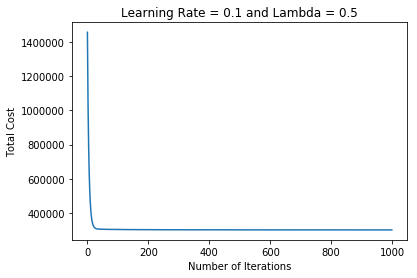

In [13]:
LR_check(x_train,y_train,1000, 0.1, 0.5)

Doing the Linear Regression and printing the Cost(MSE Error) and MAE Error of the training data:

In [14]:
tetha = LR(x_train,y_train,1000, 0.1, 0.5)
yhat_train = np.dot(tetha,x_train.transpose())
print('Cost: %e' % (cost(y_train,yhat_train)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_train,yhat_train)))

Cost: 3.015902e+05
Mean Absolute Error: 596.96


Getting the error on the test set:

In [15]:
x_test = elevate_factors(test.drop(['url','timedelta'], axis=1),2)
x_test = sc.transform(x_test)
x_test = np.concatenate((np.ones((x_test.shape[0],1)),x_test),axis=1)
y_test = test_target.values
yhat_test = np.dot(tetha,x_test.transpose())
print('Cost: %e' % (cost(y_test,yhat_test)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_test,yhat_test)))

Cost: 8.657318e+11
Mean Absolute Error: 2609.21


#### Model 2

Doing a forward elimination starting on the features with higher correlation on the target output

In [16]:
correlation = train.corr().shares
correlation.pop('shares')
correlation.pop('timedelta')
correlation.keys()

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

Iteration for the forward elimination:

In [17]:
x = pd.DataFrame()
x_ = pd.DataFrame()
error_min = 1000000000
for i in range(correlation.shape[0]):
    col = max(correlation.items(), key=operator.itemgetter(1))[0]
    correlation.pop(col)
    x[col] = train[col]
    x_train = x.values
    sc = StandardScaler()
    sc.fit(x_train)
    x_train = sc.transform(x_train)
    x_train = np.concatenate((np.ones((x_train.shape[0],1)),x_train),axis=1)
    y_train = train['shares'].values
    tetha = LR(x_train, y_train, 1000,0.1,0.5)
    yhat_train = np.dot(tetha,x_train.transpose())
    x_[col] = test[col]
    x_test = x_.values
    x_test = sc.transform(x_test)
    x_test = np.concatenate((np.ones((x_test.shape[0],1)),x_test),axis=1)
    y_test = test_target.values
    yhat_test = np.dot(tetha,x_test.transpose())
    error = mean_abs(y_test,yhat_test)
    if (error > error_min):
        x.drop(col, axis=1, inplace=True)
        x_.drop(col, axis=1, inplace=True)
    else:
        error_min = error
    final_feats = np.array(x.columns)
print('Final Features:')
print(final_feats)

Final Features:
['is_weekend' 'avg_positive_polarity' 'data_channel_is_bus'
 'max_negative_polarity' 'avg_negative_polarity' 'min_negative_polarity']


Training the model on the features of the forward elimination:

In [18]:
x_train = train[final_feats].values
x_train = elevate_factors(x_train, 2)
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_train = np.concatenate((np.ones((x_train.shape[0],1)),x_train),axis=1)
y_train = train['shares'].values

Checking the number of iterations, learning rate and lambda:

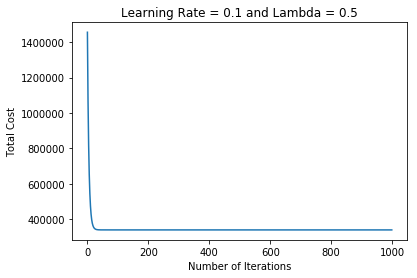

In [19]:
LR_check(x_train,y_train,1000, 0.1, 0.5)

Doing the Linear Regression and printing the Cost(MSE Error) and MAE Error of the training data:

In [20]:
tetha = LR(x_train,y_train,1000, 0.1, 0.5)
yhat_train = np.dot(tetha,x_train.transpose())
print('Cost: %e' % (cost(y_train,yhat_train)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_train,yhat_train)))

Cost: 3.388065e+05
Mean Absolute Error: 646.91


Getting the error on the test set:

In [21]:
x_test = test[final_feats].values
x_test = elevate_factors(x_test, 2)
x_test = sc.transform(x_test)
x_test = np.concatenate((np.ones((x_test.shape[0],1)),x_test),axis=1)
y_test = test_target.values
yhat_test = np.dot(tetha,x_test.transpose())
print('Cost: %e' % (cost(y_test,yhat_test)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_test,yhat_test)))

Cost: 8.658309e+11
Mean Absolute Error: 2582.05


Performing Normal Equations on the forward propagation model to compare the errors:

In [22]:
x_train = train[final_feats].values
x_train = elevate_factors(x_train, 1)
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_train = np.concatenate((np.ones((x_train.shape[0],1)),x_train),axis=1)
y_train = train['shares'].values

In [23]:
tetha = NE(x_train,y_train,0.5)
yhat_train = np.dot(tetha,x_train.transpose())
print('Cost: %e' % (cost(y_train,yhat_train)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_train,yhat_train)))

Cost: 3.388450e+05
Mean Absolute Error: 646.92


In [24]:
x_test = test[final_feats].values
x_test = elevate_factors(x_test, 1)
sc = StandardScaler()
sc.fit(x_test)
x_test = sc.transform(x_test)
x_test = np.concatenate((np.ones((x_test.shape[0],1)),x_test),axis=1)
y_test = test_target.values
yhat_test = np.dot(tetha,x_test.transpose())
print('Cost: %e' % (cost(y_test,yhat_test)))
print('Mean Absolute Error: %.2f' % (mean_abs(y_test,yhat_test)))

Cost: 8.658685e+11
Mean Absolute Error: 2581.66
